In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# I. Data Methodology

In [2]:
def combine_series(series1, series2):
    temp_series1 = series1[series1.index <= series2.index[0]]
    temp_series1 = temp_series1 / temp_series1.iloc[-1] * series2.iloc[0]
    temp_series2 = pd.concat([temp_series1.iloc[:-1], series2], axis=0)
    return temp_series2

In [3]:
tickers = ['^GSPC', '^SP500TR', 'SPY']
df = yf.download(tickers)['Adj Close']

daily_spx_price = df['SPY'].dropna()
daily_spx_price = combine_series(df['^SP500TR'].dropna(), daily_spx_price)
daily_spx_price = combine_series(df['^GSPC'].dropna(), daily_spx_price)
daily_spx_returns = (daily_spx_price.shift(-1) / daily_spx_price - 1).dropna()

temp = daily_spx_price.asfreq('D', 'bfill')
monthly_spx_price = temp[temp.index.day == 1]
monthly_spx_returns = (monthly_spx_price.shift(-1) / monthly_spx_price - 1).dropna()

annual_spx_price = monthly_spx_price[monthly_spx_price.index.month == 1]
annual_spx_returns = (annual_spx_price.shift(-1) / annual_spx_price - 1).dropna()

[*********************100%***********************]  3 of 3 completed


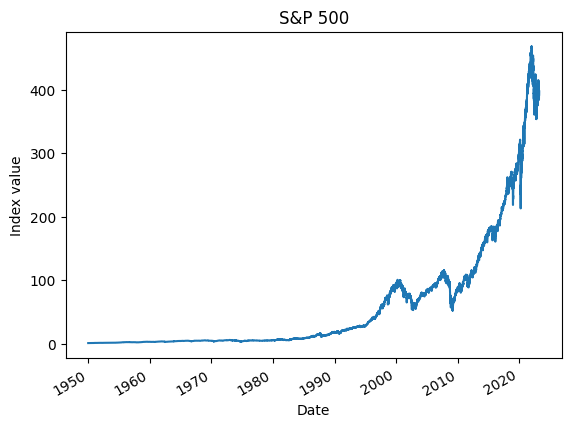

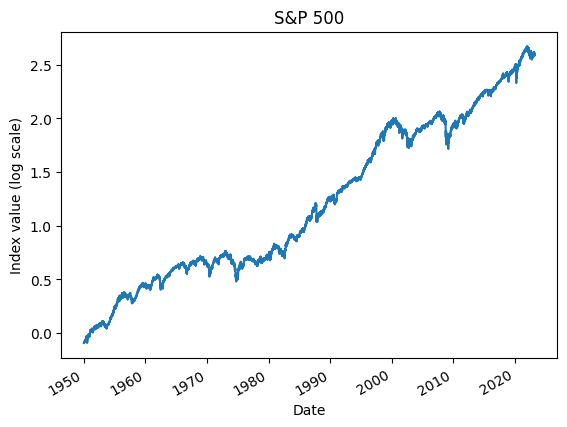

In [4]:
daily_spx_price.plot()
plt.title('S&P 500')
plt.xlabel('Date')
plt.ylabel('Index value')
plt.show()

np.log10(daily_spx_price).plot()
plt.title('S&P 500')
plt.xlabel('Date')
plt.ylabel('Index value (log scale)')
plt.show()

# II. Turn of the Month Effect  

In [5]:
def get_trading_day_of_month(series):
    trading_day_of_month = []
    count = 0
    month = series.index[0].month
    for i in series.index:
        if i.month != month:
            count = 1
            month = i.month
        else:
            count += 1
        trading_day_of_month.append(count)
    return pd.Series(trading_day_of_month, index=series.index)

In [6]:
trading_day_of_month = get_trading_day_of_month(daily_spx_price)
df = pd.concat([daily_spx_returns, trading_day_of_month], axis=1)
df.columns = ['daily_spx_returns', 'trading_day_of_month']

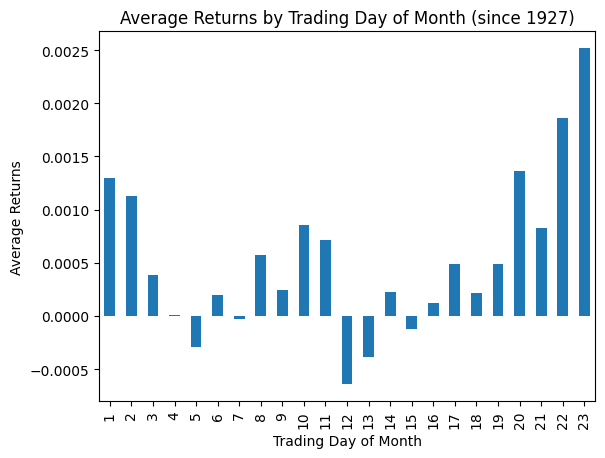

In [7]:
average_returns_by_trading_day_of_month = df.groupby('trading_day_of_month')['daily_spx_returns'].mean()
average_returns_by_trading_day_of_month.plot.bar()
plt.title('Average Returns by Trading Day of Month (since 1927)')
plt.xlabel('Trading Day of Month')
plt.ylabel('Average Returns')
plt.show()

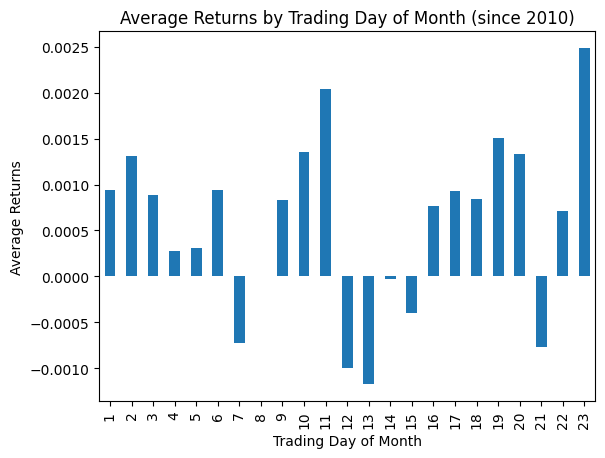

In [8]:
temp_df = df[df.index.year >= 2010]
average_returns_by_trading_day_of_month = temp_df.groupby('trading_day_of_month')['daily_spx_returns'].mean()
average_returns_by_trading_day_of_month.plot.bar()
plt.title('Average Returns by Trading Day of Month (since 2010)')
plt.xlabel('Trading Day of Month')
plt.ylabel('Average Returns')
plt.show()

In [9]:
strategy_returns = df['daily_spx_returns'] * (df['trading_day_of_month'].isin([1, 2, 3, 20, 21, 22, 23]))
strategy_equity = (1+strategy_returns).cumprod()
strategy_equity = strategy_equity.asfreq('D', 'bfill')

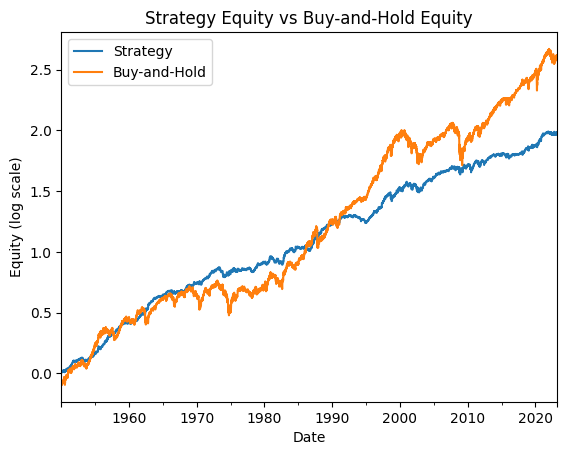

In [10]:
np.log10(strategy_equity).plot()
np.log10(daily_spx_price).plot()
plt.title('Strategy Equity vs Buy-and-Hold Equity')
plt.xlabel('Date')
plt.ylabel('Equity (log scale)')
plt.legend(['Strategy', 'Buy-and-Hold'])
plt.show()

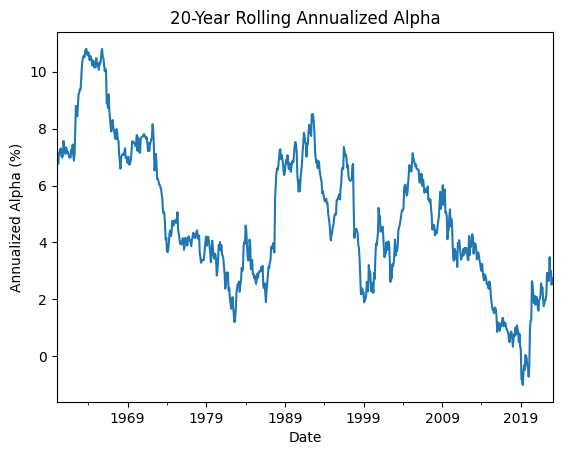

In [11]:
monthly_strategy_equity = strategy_equity[strategy_equity.index.day == 1]
monthly_strategy_returns = (monthly_strategy_equity.shift(-1) / monthly_strategy_equity - 1).dropna()

X = sm.add_constant(monthly_spx_returns)
rols = RollingOLS(monthly_strategy_returns, X, window=120)
rres = rols.fit()
params = rres.params.copy()
(params['const']*1200).dropna().plot()
plt.title('20-Year Rolling Annualized Alpha')
plt.xlabel('Date')
plt.ylabel('Annualized Alpha (%)')
plt.show()

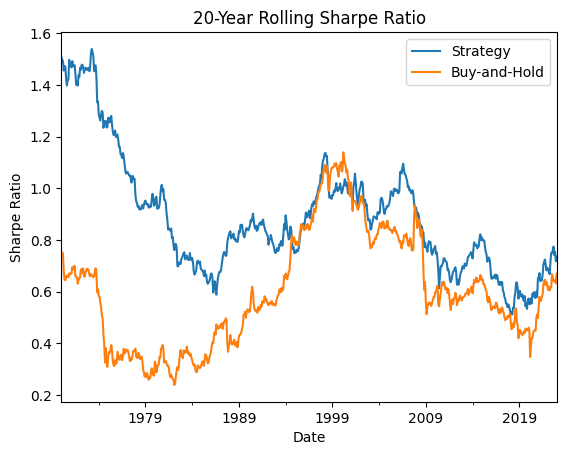

In [12]:
strategy_rolling_sharpe = monthly_strategy_returns.rolling(240).mean() / monthly_strategy_returns.rolling(240).std() * 12**.5
benchmark_rolling_sharpe = monthly_spx_returns.rolling(240).mean() / monthly_spx_returns.rolling(240).std() * 12**.5

strategy_rolling_sharpe.dropna().plot()
benchmark_rolling_sharpe.dropna().plot()
plt.title('20-Year Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Strategy', 'Buy-and-Hold'])
plt.show()

# III. January Effect

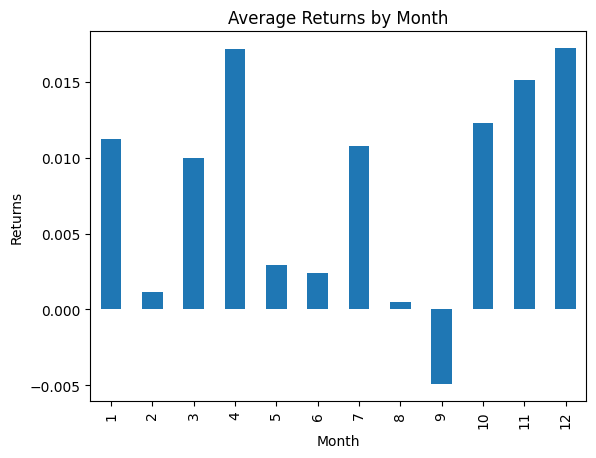

In [13]:
monthly_spx_returns.groupby(monthly_spx_returns.index.month).mean().plot.bar()
plt.title('Average Returns by Month')
plt.xlabel('Month')
plt.ylabel('Returns')
plt.show()

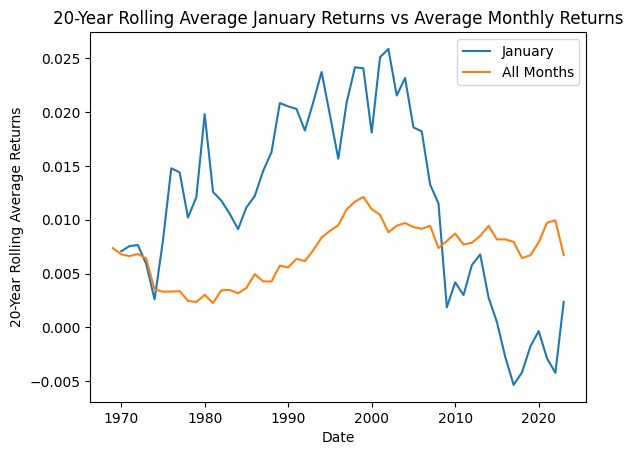

In [14]:
jan_returns = monthly_spx_returns[monthly_spx_returns.index.month == 1]
jan_returns.groupby(jan_returns.index.year).mean().rolling(20).mean().plot()
non_jan_returns = monthly_spx_returns[monthly_spx_returns.index.month != 1]
non_jan_returns.groupby(non_jan_returns.index.year).mean().rolling(20).mean().plot()

plt.title('20-Year Rolling Average January Returns vs Average Monthly Returns')
plt.xlabel('Date')
plt.ylabel('20-Year Rolling Average Returns')
plt.legend(['January', 'All Months'])
plt.show()

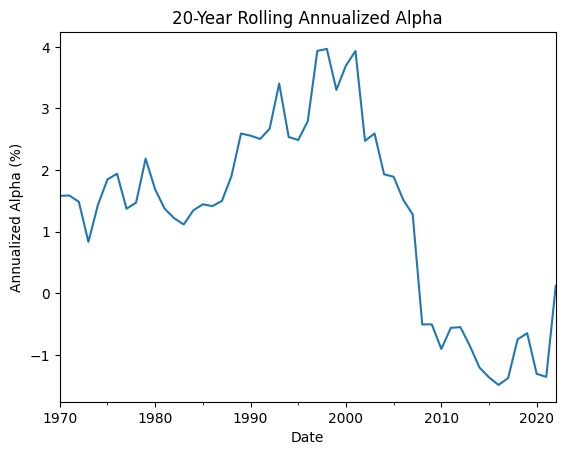

In [15]:
strategy_returns = monthly_spx_returns * (monthly_spx_returns.index.month == 1)
strategy_equity = (1+strategy_returns).cumprod()
annual_strategy_equity = strategy_equity[(strategy_equity.index.month == 1)]
annual_strategy_returns = (annual_strategy_equity.shift(-1) / annual_strategy_equity - 1).dropna()

X = sm.add_constant(annual_spx_returns)
rols = RollingOLS(annual_strategy_returns, X, window=20)
rres = rols.fit()
params = rres.params.copy()
(params['const']*100).dropna().plot()
plt.title('20-Year Rolling Annualized Alpha')
plt.xlabel('Date')
plt.ylabel('Annualized Alpha (%)')
plt.show()

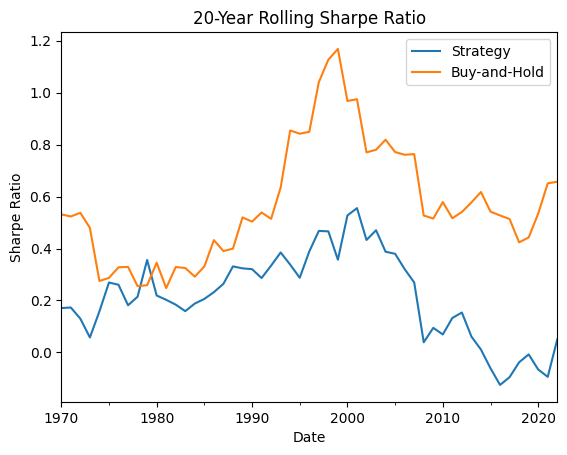

In [16]:
strategy_rolling_sharpe = annual_strategy_returns.rolling(20).mean() / annual_strategy_returns.rolling(20).std()
benchmark_rolling_sharpe = annual_spx_returns.rolling(20).mean() / annual_spx_returns.rolling(20).std()

strategy_rolling_sharpe.dropna().plot()
benchmark_rolling_sharpe.dropna().plot()
plt.title('20-Year Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Strategy', 'Buy-and-Hold'])
plt.show()

# IV. January Barometer

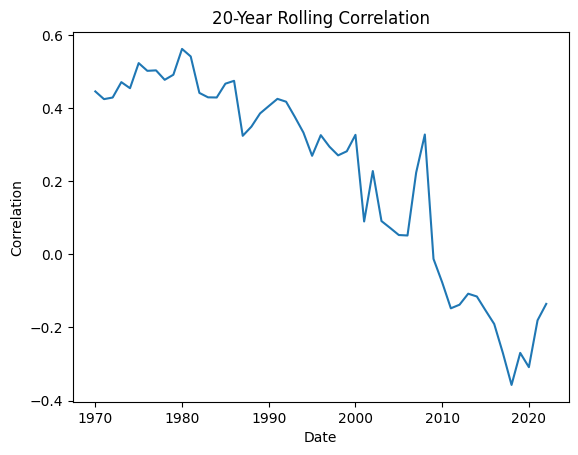

In [17]:
start_index = np.where(monthly_spx_price.index.month==1)[0]

jan_returns = monthly_spx_price.values[start_index+1]/monthly_spx_price.values[start_index]-1
jan_returns = pd.Series(jan_returns, index=monthly_spx_price.index[start_index].year)
non_jan_returns = monthly_spx_price.values[start_index[1:]]/monthly_spx_price.values[start_index[:-1]+1]-1
non_jan_returns = pd.Series(non_jan_returns, index=monthly_spx_price.index[start_index[:-1]].year)

df = pd.concat([jan_returns, non_jan_returns], axis=1)
df.columns = ['jan_returns', 'non_jan_returns']

df.rolling(20).corr().unstack().iloc[:, 2].plot()
plt.title('20-Year Rolling Correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()

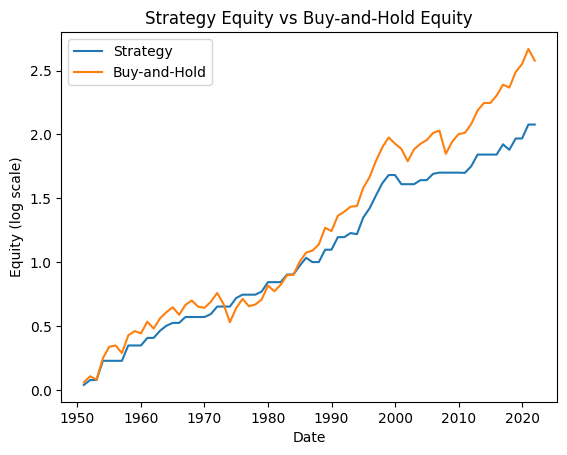

In [18]:
annual_strategy_returns = non_jan_returns * (jan_returns.iloc[:-1]>0)
temp_annual_spx_returns = annual_spx_returns.copy(deep=True)
temp_annual_spx_returns.index = temp_annual_spx_returns.index.year

np.log10((annual_strategy_returns+1).cumprod()).plot()
np.log10((temp_annual_spx_returns+1).cumprod()).plot()
plt.title('Strategy Equity vs Buy-and-Hold Equity')
plt.xlabel('Date')
plt.ylabel('Equity (log scale)')
plt.legend(['Strategy', 'Buy-and-Hold'])
plt.show()

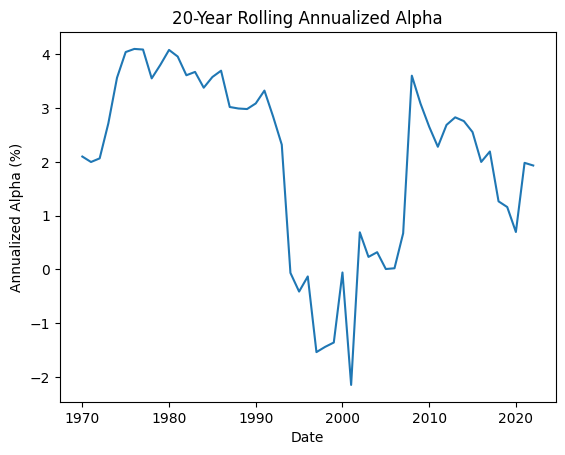

In [19]:
X = sm.add_constant(temp_annual_spx_returns)
rols = RollingOLS(annual_strategy_returns, X, window=20)
rres = rols.fit()
params = rres.params.copy()
(params['const']*100).plot()
plt.title('20-Year Rolling Annualized Alpha')
plt.xlabel('Date')
plt.ylabel('Annualized Alpha (%)')
plt.show()

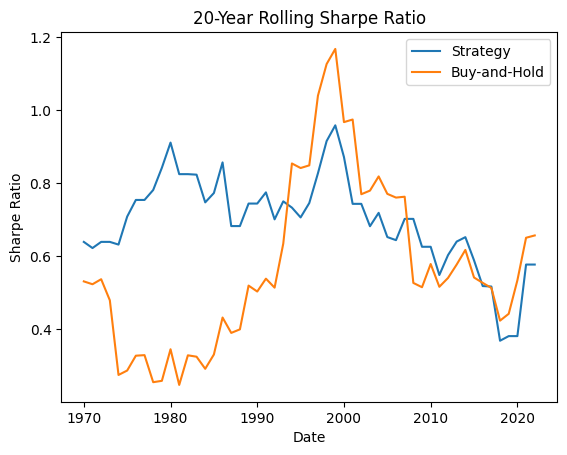

In [20]:
strategy_rolling_sharpe = annual_strategy_returns.rolling(20).mean() / annual_strategy_returns.rolling(20).std()
benchmark_rolling_sharpe = annual_spx_returns.rolling(20).mean() / annual_spx_returns.rolling(20).std()
benchmark_rolling_sharpe.index = benchmark_rolling_sharpe.index.year

strategy_rolling_sharpe.plot()
benchmark_rolling_sharpe.plot()
plt.title('20-Year Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Strategy', 'Buy-and-Hold'])
plt.show()